# Introduction
This small project is focused on cleaning, analyzing dataset and comparing different algorithms for natural language processing.
<br>
For this purpose I've chose 'Twitter posts data' from Kaggle because it has a lot of casual expressions.
<br><br>
#### The process include:
- Data overview and analysis
- Data cleaning, modulations, custom functions.
- Building AI Model
<br><br>
#### Libraries I've used:
- Pandas
- Seaborn
- SciKit Learn
- NLTK
<br>
###### '#' content means that I used something but it didn't produced any significant improvement on the model.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Data preview

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
val = pd.read_csv('val.csv')
df = pd.concat([train, test], ignore_index=True)
df

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy
...,...,...
6750,Why does Candice constantly pout #GBBO 💄😒,sadness
6751,"@redBus_in #unhappy with #redbus CC, when I ta...",sadness
6752,"@AceOperative789 no pull him afew weeks ago, s...",sadness
6753,I'm buying art supplies and I'm debating how s...,sadness


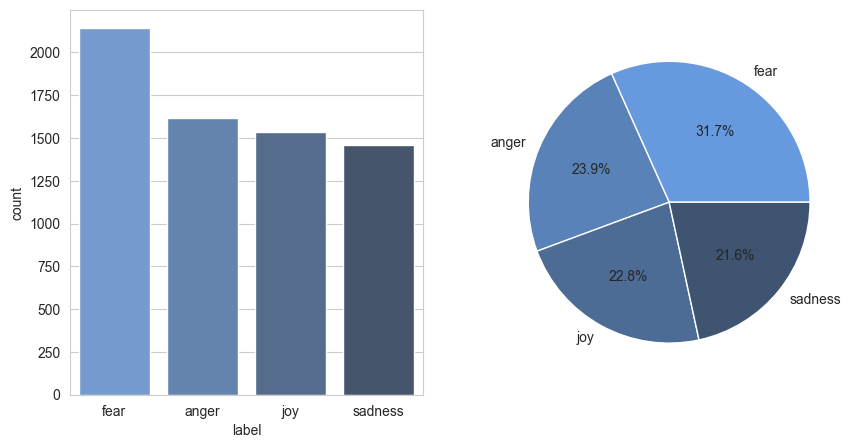

In [3]:
sns.set_style("whitegrid")
palette = sns.dark_palette("#69d", reverse=True)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
grouped = df.groupby('label', as_index=False).count().sort_values(by='text', ascending=False)
sorted_order = grouped['label'].tolist()
sns.countplot(df, x='label', ax=axes[0], palette=palette, order=sorted_order)
axes[1] = plt.pie(x=grouped['text'], labels=grouped['label'], autopct='%1.1f%%', colors=palette)

Dropping off outliers and duplicates

mean: 16.06099185788305
harmoinc mean: 12.172598113316539


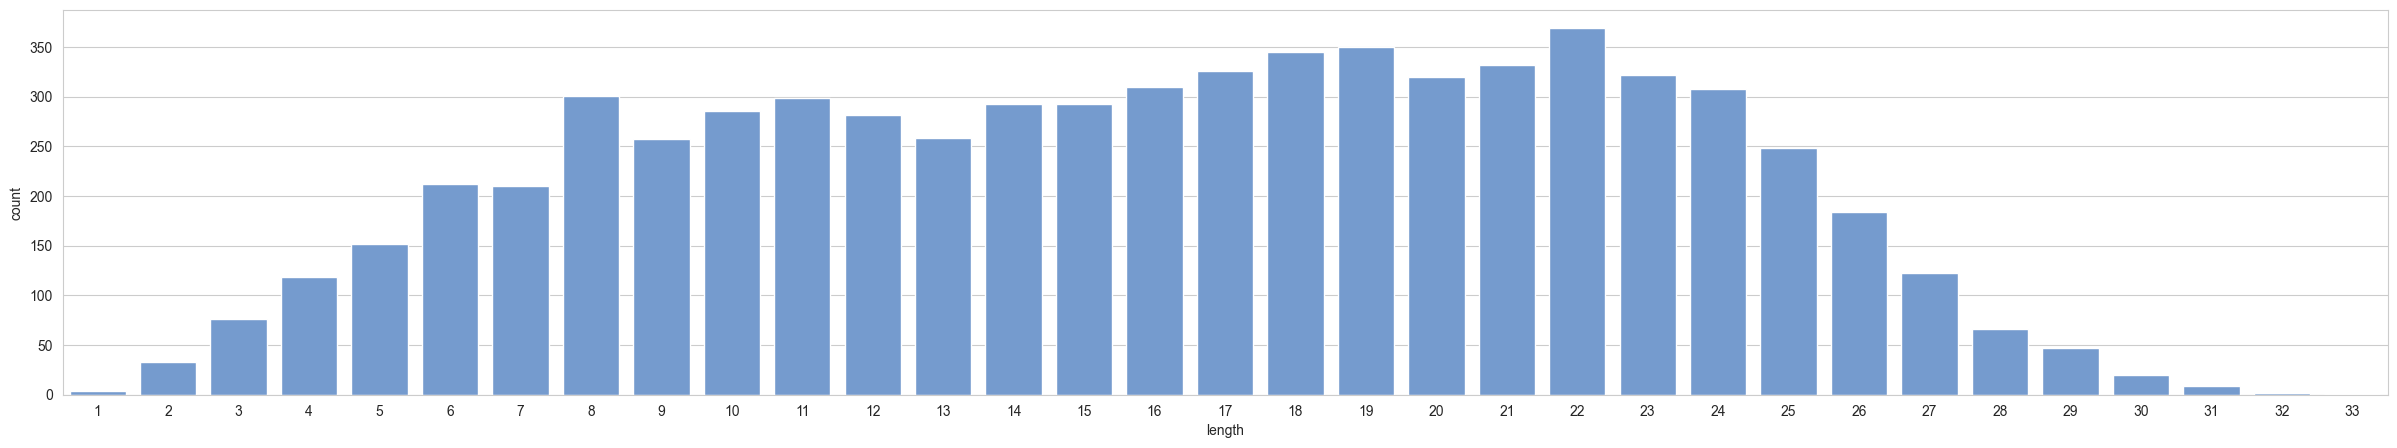

In [4]:
from scipy.stats import hmean
from numpy import mean

df['length'] = df['text'].apply(lambda x: len(x.split()))
plt.subplots(figsize=(30, 5))
sns.countplot(df, x='length', color=palette[0])

print(f"mean: {mean(df['length'])}")
print(f"harmoinc mean: {hmean(df['length'])}")

df = df[df['length'] < 32]
#df = df[df['length'] > 1]
df = df.drop('length', axis=1)

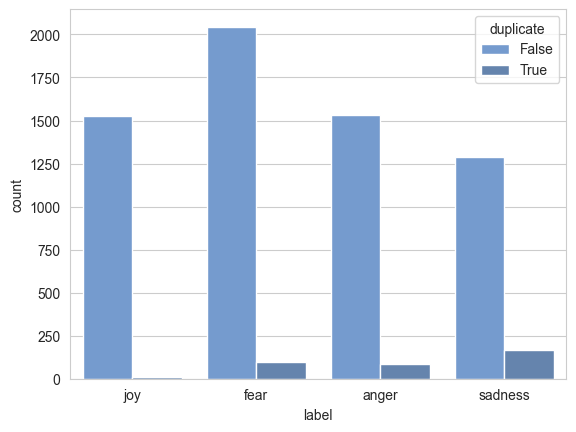

In [5]:
df['duplicate'] = df.duplicated(subset='text', keep=False)
sns.countplot(data=df, x='label', hue='duplicate', palette=palette)
df = df.drop_duplicates(subset='text', keep=False)
df = df.drop('duplicate', axis=1)

#### Downsizing classes

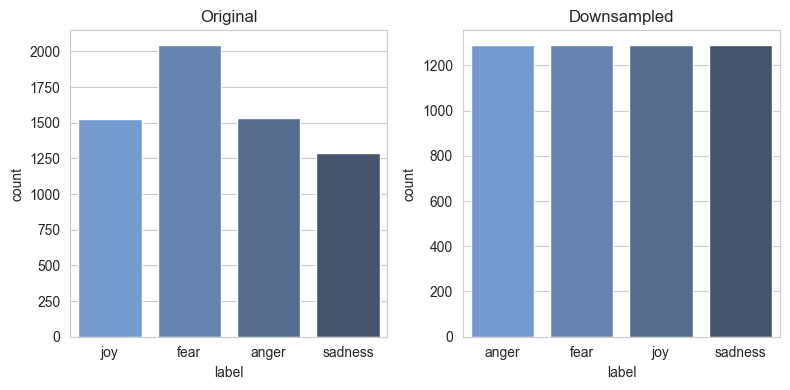

In [6]:
from sklearn.utils import resample

labeled = lambda i: df[df['label'] == i]
downsampled_df = pd.DataFrame(data=labeled(5))

''' This loop downsizes all the classes inside of the dataframe by taking smallest one ('sadness') and applying it's length to the rest '''
for i in ['anger', 'fear', 'joy', 'sadness']:
    downsampled_class = resample(labeled(i),
                                 replace=False,
                                 n_samples=len(labeled('sadness')),
                                 random_state=42)
    downsampled_df = pd.concat([downsampled_df, downsampled_class])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

unbalanced = sns.countplot(df, x='label', ax=axes[0], hue='label', palette=palette)
unbalanced.set_title('Original')

balanced = sns.countplot(downsampled_df, x='label', ax=axes[1], hue='label', palette=palette)
balanced.set_title('Downsampled')

plt.tight_layout()

#### Custom tokenizer
Based on NLTK I've made some kind of tokenizer that can convert emojis to words and remove mentions ("@").

In [7]:
emoji_to_word = {
    "😀": "happy",
    "😃": "happy",
    "😄": "happy",
    "😁": "happy",
    "😆": "happy",
    "😊": "happy",
    "😎": "cool",
    "😍": "love",
    "😘": "love",
    "😗": "kiss",
    "😙": "kiss",
    "😚": "kiss",
    "☺️": "happy",
    "🙂": "happy",
    "🤗": "hug",
    "🤔": "thinking",
    "😐": "neutral",
    "😑": "neutral",
    "😶": "neutral",
    "🙄": "annoyed",
    "😏": "smirk",
    "😣": "suffering",
    "😥": "sad",
    "😪": "sleepy",
    "😫": "tired",
    "😢": "crying",
    "😭": "crying",
    "😤": "angry",
    "😠": "angry",
    "😡": "angry",
    "😷": "sick",
    "🤒": "sick",
    "🤕": "injured",
    "🤢": "nauseated",
    "🤮": "vomiting",
    "🤧": "sneezing",
    "😵": "dizzy",
    "🤯": "mind blown",
    "😲": "surprised",
    "😳": "shy",
    "🥺": "pleading",
    "😦": "frowning",
    "😧": "anguished",
    "😨": "fearful",
    "😰": "anxious",
    "😥": "sad",
    "😢": "sad",
    "😱": "screaming",
    "😖": "confounded",
    "😣": "persevering",
    "😞": "disappointed",
    "😓": "sweat",
    "😩": "weary",
    "😫": "tired",
    "😤": "frustrated",
    "😡": "pouting",
    "😠": "angry",
    "🤬": "cursing",
    "😈": "devilish",
    "👿": "angry",
    "💀": "skull",
    "☠️": "skull",
    "💩": "poop",
    "🤡": "clown",
    "👹": "monster",
    "👺": "goblin",
    "👻": "ghost",
    "👽": "alien",
    "👾": "alien",
    "🤖": "robot",
    "😺": "smiling cat",
    "😸": "grinning cat",
    "😹": "laughing cat",
    "😻": "heart eyes cat",
    "😼": "smirk cat",
    "😽": "kissing cat",
    "🙀": "screaming cat",
    "😿": "crying cat",
    "😾": "pouting cat",
}
verb_dict = {
    'u': 'you',
    'r': 'are',
    'hv': 'have',
    'gt': 'get',
    'cn': 'can',
    'nt': 'not',
    'dn': 'do not',
    'hvnt': 'have not',
    'wnt': 'want',
}

In [8]:
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.corpus import stopwords

wnl = WordNetLemmatizer()
ss = SnowballStemmer("english")
token = RegexpTokenizer(r'\w+')
example = test.iloc[697]['text']
#example = "@josh @kriss XD. that's so sad"

def text_cleaner(data):
    result = ' '.join([w for w in data.split() if w[0] != '@'])
    result = ''.join([emoji_to_word[w] if w in emoji_to_word.keys() else w for w in result])
    result = ' '.join([verb_dict[w] if w in verb_dict else w for w in result.split()])
    result = token.tokenize(result)
    #result = [w for w in result if w not in stopwords.words('english')]
    #result = [wnl.lemmatize(w) for w in result]
    result = [ss.stem(w) for w in result]
    return result

print('Before:\n', example)
print('\nAfter:\n', text_cleaner(example))

Before:
 when u havent learned to swim 🤔 but you keep working out so you're denser and less buoyant 😞 but swimming is scary 🤔 but also u cant swim 😞

After:
 ['when', 'you', 'havent', 'learn', 'to', 'swim', 'think', 'but', 'you', 'keep', 'work', 'out', 'so', 'you', 're', 'denser', 'and', 'less', 'buoyant', 'disappoint', 'but', 'swim', 'is', 'scari', 'think', 'but', 'also', 'you', 'cant', 'swim', 'disappoint']


# The Model
Following Naive Bayes and Stochastic Gradient Descent I've made some comparision with 2 versions of data (original class sizes and downsized) to see how each of these affects the results. 

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

x, y = df['text'], df['label']
x2, y2 = downsampled_df['text'], downsampled_df['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, random_state=0, test_size=0.2)

''' CNB_1, SGD_1: unbalanced data, CNB_2, SGD_2: balanced data '''
CNB_1 = Pipeline([
    ('vec', CountVectorizer(tokenizer=text_cleaner, stop_words=stopwords.words('english'))),
    ('clf', ComplementNB())
])

SGD_1 = Pipeline([
    ('vec', CountVectorizer(tokenizer=text_cleaner, stop_words=stopwords.words('english'))),
    ('clf', SGDClassifier(random_state=0, n_jobs=-1, penalty=None, shuffle=True, max_iter=100_000,
                          loss='modified_huber', learning_rate='constant', eta0=0.01, alpha=0.00011, epsilon=0.4, l1_ratio=0.7)),
])

CNB_2 = Pipeline([
    ('vec', CountVectorizer(tokenizer=text_cleaner, stop_words=stopwords.words('english'))),
    ('clf', ComplementNB())
])

SGD_2 = Pipeline([
    ('vec', CountVectorizer(tokenizer=text_cleaner, stop_words=stopwords.words('english'))),
    ('clf', SGDClassifier(random_state=0, n_jobs=-1, penalty='l1', shuffle=True, max_iter=100_000,
                          loss='epsilon_insensitive', learning_rate='invscaling', eta0=0.41, alpha=0.00012, epsilon=0.2, l1_ratio=0.6)),
])

SGD_1.fit(x_train, y_train)
y_pred_sgd = SGD_1.predict(x_test)

CNB_1.fit(x_train, y_train)
y_pred_cnb = CNB_1.predict(x_test)

SGD_2.fit(x_train2, y_train2)
y_pred_sgd2 = SGD_2.predict(x_test2)

CNB_2.fit(x_train2, y_train2)
y_pred_cnb2 = CNB_2.predict(x_test2)


#### Results


ComplementNB classification report

              precision    recall  f1-score   support

       anger       0.89      0.94      0.91       322
        fear       0.92      0.90      0.91       396
         joy       0.89      0.93      0.91       298
     sadness       0.92      0.85      0.88       263

    accuracy                           0.91      1279
   macro avg       0.91      0.91      0.91      1279
weighted avg       0.91      0.91      0.91      1279



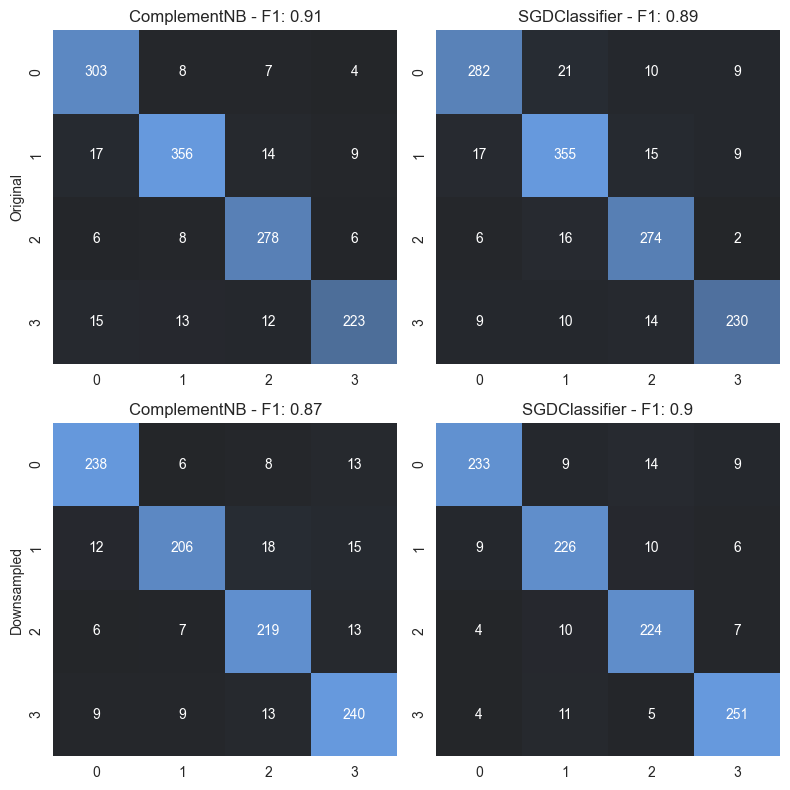

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

print('\nComplementNB classification report',classification_report(y_test, y_pred_cnb), sep='\n\n')

cmat = confusion_matrix(y_test, y_pred_cnb), confusion_matrix(y_test, y_pred_sgd), confusion_matrix(y_test2, y_pred_cnb2), confusion_matrix(y_test2, y_pred_sgd2)

f1 = (round(f1_score(y_test, y_pred_cnb, average='macro'), 2),
      round(f1_score(y_test, y_pred_sgd, average='macro'), 2),
      round(f1_score(y_test2, y_pred_cnb2, average='macro'), 2),
      round(f1_score(y_test2, y_pred_sgd2, average='macro'), 2))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for i in range(4):
    sns.heatmap(cmat[i], annot=True, fmt='d', cbar=False, cmap=sns.dark_palette("#69d", reverse=False, as_cmap=True), ax=axes.flat[i])
axes.flat[0].set_ylabel('Original')
axes.flat[2].set_ylabel('Downsampled')

axes.flat[0].set_title(f'ComplementNB - F1: {f1[0]}')
axes.flat[1].set_title(f'SGDClassifier - F1: {f1[1]}')
axes.flat[2].set_title(f'ComplementNB - F1: {f1[2]}')
axes.flat[3].set_title(f'SGDClassifier - F1: {f1[3]}')
plt.tight_layout()


#### Testing in practice

In [11]:
practical_test = {
'anger': [
    "I am consumed by an overwhelming sense of fury today.",
    "My anger is so intense that it feels like it could consume me.",
    "I am so enraged that I can barely think straight.",
    "My frustration is reaching a boiling point and I fear I may explode.",
    "I am seething with such intense rage that it feels like my blood is on fire.",
    "I am absolutely livid to the point where I can feel my face turning red.",
    "My anger is so deep and intense that it feels like it could consume my entire being.",
    "I am fuming with such intense anger that I can feel the heat radiating off of me.",
    "I am filled with an uncontrollable rage that is pulsating through every fiber of my being.",
    "My wrath and fury are so overwhelming that I fear I may lose control and unleash it upon the world."
],
'fear': [
    "The weight of fear bears down on me heavily today.",
    "Every step I take is accompanied by a nagging fear in the pit of my stomach.",
    "The air feels thick with fear as I go about my day.",
    "Today, fear has become my constant companion, whispering doubts and insecurities in my ear.",
    "My mind is consumed by a never-ending loop of fearful thoughts and worst-case scenarios.",
    "The world seems to be a darker, scarier place today, as fear colors my perception.",
    "Fear has become a suffocating presence, making it hard to breathe and think clearly.",
    "Today, I am paralyzed by fear, unable to move forward or make decisions.",
    "The grip of fear tightens with each passing moment, making it hard to find any sense of peace or calm.",
    "Today, fear has become a relentless adversary, constantly reminding me of my vulnerabilities and weaknesses."
],
'joy': [
    "Every moment today is filled with joy and gratitude.",
    "I am basking in the warmth of happiness and contentment today.",
    "Today, my soul is singing with joy and fulfillment.",
    "I am surrounded by love and happiness on this beautiful day.",
    "Today, I am truly appreciating the abundance of joy in my life.",
    "My heart is overflowing with happiness and peace on this special day.",
    "I am embracing every moment with a heart full of joy and gratitude.",
    "Today, I am reminded of all the blessings that bring me happiness.",
    "I am savoring every moment of joy and bliss that today brings.",
    "Today is a day to celebrate and cherish the happiness that fills my heart."
],
'sadness': [
    "Today, a heavy cloud of sadness engulfs my heart.",
    "The weight of sorrow burdens my soul on this day.",
    "A deep sense of melancholy permeates my being today.",
    "My spirit is consumed by a profound sadness that lingers within me.",
    "A somber mood casts a shadow over my day, leaving me feeling downcast.",
    "Today, my heart is filled with a profound sadness that I cannot shake off.",
    "A wave of sorrow washes over me, leaving me feeling desolate.",
    "The weight of sadness bears heavily upon me, making this day a struggle.",
    "A sense of gloom and despair envelops me, making it hard to find solace.",
    "Today, I am overcome by a profound sadness that taints every aspect of my existence."
]
}

practical_score = pd.DataFrame(columns=['emotion', 'score [CNB]', 'score [SGD]'])

for emotion, sentences in practical_test.items():
    score_cnb = 0
    score_sgd = 0
    for s in sentences:
        outcome_cnb = CNB_2.predict([s])
        outcome_sgd = SGD_2.predict([s])
        if outcome_cnb == emotion:
            score_cnb += 1
        if outcome_sgd == emotion:
            score_sgd += 1
    practical_score.loc[len(practical_score.index)] = [emotion, score_cnb*10, score_sgd*10]

print("ComplementNB:", practical_score['score [CNB]'].mean(), '%')
print("SGDClassifier:", practical_score['score [SGD]'].mean(), '%')
practical_score

ComplementNB: 95.0 %
SGDClassifier: 92.5 %


,emotion,score [CNB],score [SGD]
0,anger,100,100
1,fear,100,90
2,joy,100,100
3,sadness,80,80


#### Hyperparameter optimization

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

parameters = {
    #'vec__ngram_range': [(1,1), (1,2), (1,3)],
    #'clf__shuffle': [True, False],
    'clf__alpha': [n/100_000 for n in range(5, 15)],
    'clf__loss': ['hinge', 'log_loss', 'modified_huber', 'perceptron', 'huber', 'epsilon_insensitive'],
    'clf__penalty': ['elasticnet', 'l1', 'l2', None],
    'clf__epsilon': [n/10 for n in range(11)],
    'clf__learning_rate': ['constant', 'optimal', 'adaptive', 'invscaling'],
    'clf__eta0': [n/100 for n in range(1, 101, 10)],
    'clf__l1_ratio': [n/10 for n in range(0, 11)]
}

rs = RandomizedSearchCV(param_distributions=parameters, n_iter=1_000, cv=10, random_state=0, estimator=SGD_1, n_jobs=-1)
rs.fit(val['text'], val['label'])

print(rs.best_score_)
print(rs.best_params_)

# Conclusion
Even though dataset contains raw posts in casual language It's still possible to create some kind of sentiment AI classificator based on these sentences.<br>
In practice however, It highly depends on how complicated the context and structure of sentence is.